In [4]:
import sys, os 
#sys.path.insert(0,r"C:\Users\labadmin\Documents\suite2p")
#sys.path.insert(0,r"C:\Users\labadmin\Documents\rastermap")
import numpy as np 
import pandas as pd
from src import utils, plots, redcells
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
m1 = utils.load_mouse('VG15','2024_10_16', '2', load_neurons=True, interp_behav=True, load_retinotopy=False)

Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG15\2024_10_16\2
Creating new mouse object ...
Timeline with fname: Timeline_VG15_2024_10_16_2.mat not found, trying with fname: VG15_2024_10_16_2.mat 
Timeline file is in v7.3 format, loading with h5py
planes: 20


100%|██████████| 20/20 [07:04<00:00, 21.22s/it]

*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr'])


# frame selector dataframe
* extra steps are due to add the istim column to the dataframe
    * the index is the frame number and the columns are the labels associated with the frame

In [6]:
m1.frameselector = utils.get_frameselector(m1)
istim_df = pd.DataFrame(m1._timeline['istim'], columns=['istim'])
istim_df["trial_no"] = np.arange(0, len(istim_df)).astype(float)
m1.frameselector = pd.merge(m1.frameselector, istim_df, left_on='trial_no', right_on='trial_no', how='left')

In [7]:
m1.frameselector

,trial_no,trial_type,contrast,speed,distance,reward_delivery,intertrial,time_fromstart,time_within_trial,istim
0,1.0,non rewarded,0.024824,4.159781,3.723540,NaN,False,0.142848,0.000000,1.0
1,1.0,non rewarded,0.099944,4.497560,14.991549,NaN,False,0.333814,0.190966,1.0
2,1.0,non rewarded,0.248785,2.279286,37.317821,NaN,False,0.685381,0.542533,1.0
3,1.0,non rewarded,0.380595,2.811893,57.089224,NaN,False,1.001835,0.858987,1.0
4,1.0,non rewarded,0.500199,4.218163,75.029890,NaN,False,1.286676,1.143828,1.0
...,...,...,...,...,...,...,...,...,...,...
9864,399.0,non rewarded,0.000000,0.105500,337.050000,NaN,True,3109.093043,6.660635,1.0
9865,399.0,non rewarded,0.000000,3.878952,356.809159,NaN,True,3109.447105,7.014697,1.0
9866,399.0,non rewarded,0.000000,4.494551,376.211092,NaN,True,3109.755573,7.323165,1.0
9867,399.0,non rewarded,0.000000,3.771202,395.220587,NaN,True,3110.057854,7.625446,1.0


# get high snr neurons

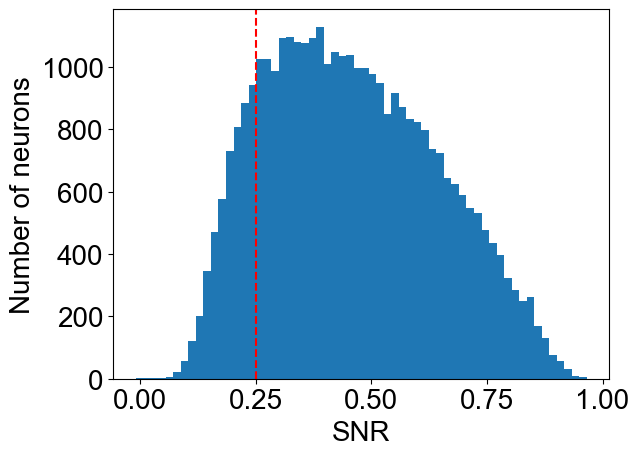

In [8]:
plt.hist(m1._snr, bins=60);
plt.xlabel('SNR')
plt.ylabel('Number of neurons')
# plot a line at the treshold .25
plt.axvline(x=.25, color='r', linestyle='--')

In [9]:
m1._spks = m1._spks[m1._snr>=.25]
m1._xpos = m1._xpos[m1._snr>=.25]
m1._ypos = m1._ypos[m1._snr>=.25]
m1._iplane = m1._iplane[m1._snr>=.25]
m1._spks.shape, m1._xpos.shape, m1._ypos.shape, m1._iplane.shape

((30110, 9935), (30110,), (30110,), (30110,))

10 example neurons with high snr

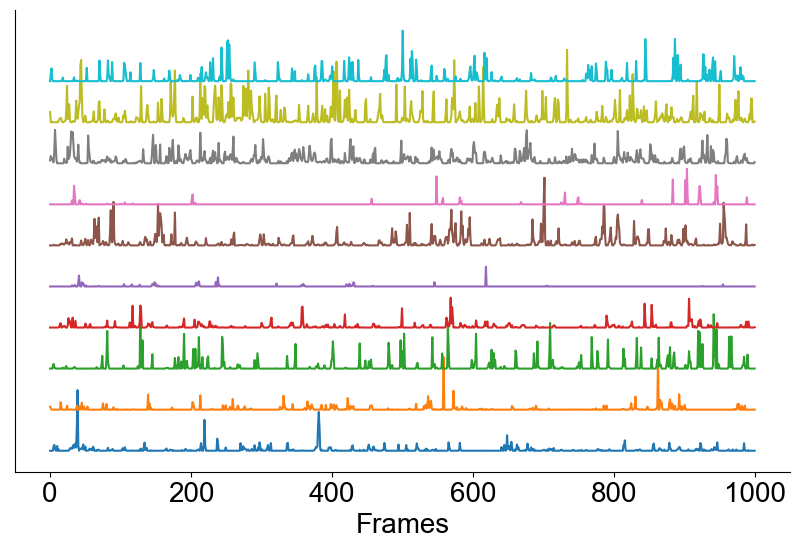

In [10]:
plt.figure(figsize=(10, 6))
# pick 10 random neurons and plot their spikes
neurons = np.random.choice(m1._spks.shape[0], 10)
for i, n in enumerate(neurons):
    plt.plot(m1._spks[n,:1000] + (i) *10)
plt.xlabel('Frames')
plt.ylabel("")
plt.yticks([])
sns.despine()
plt.show()

# get the interpolated data, we end up having a matrix (nneurons, trials, position)

In [11]:
m1.interp_spks = utils.interp_spks_by_corridorlength(m1, m1.frameselector, z = True, corridor_length=400)

0 9869
interpolating 30110 neurons, 9870 frames to
the vector of distance with shape: (9870,)
neurons: 30110, trials: 399, corridor length: 400


In [12]:
m1.interp_spks.shape

(30110, 399, 400)

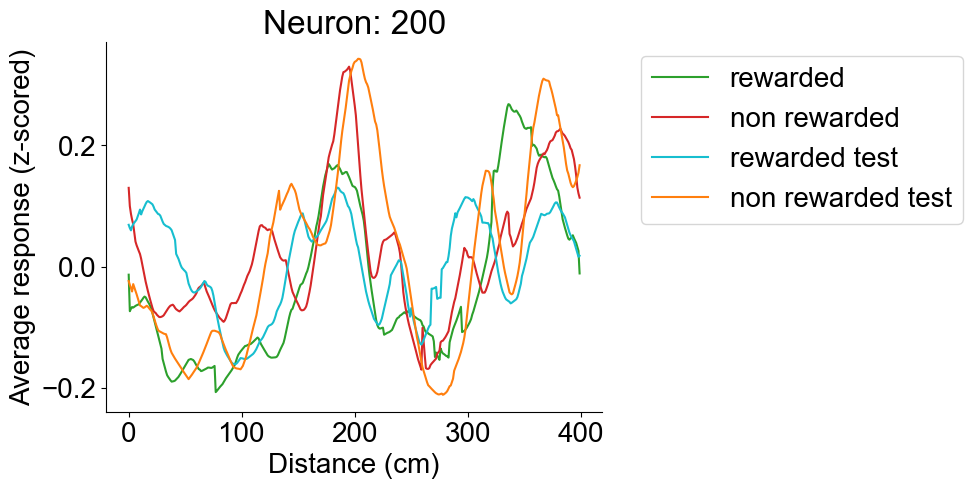

In [13]:
m1.trial_dict = utils.get_trialno_bytype(m1.frameselector)
opt_dict = {
    "rewarded": "tab:green",
    "non rewarded": "tab:red",
    "rewarded test": "tab:cyan",
    "non rewarded test": "tab:orange",
}
neuron = 200
for k, v in m1.trial_dict.items():
    trial_response = m1.interp_spks[:,v,:]
    avg_response = np.mean(trial_response, axis=1)
    plt.plot(avg_response[neuron,:], label=k, color=opt_dict[k])
plt.title(f'Neuron: {neuron}')
plt.xlabel('Distance (cm)')
plt.ylabel('Average response (z-scored)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()

# compute dprime

In [14]:
utils.compute_dprime(m1, discrimination_region = (25,275), corridor_length = 400, nogray = False)

dprime saved in MouseObject.train_dp (neurons) using even trials
projected_response saved in MouseObject.projected_response (neurons x trials x positions)


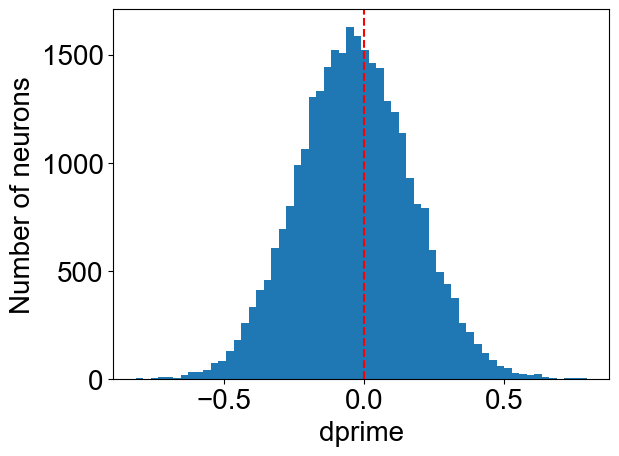

In [15]:
plt.hist(m1.train_dp, bins=60);
plt.xlabel('dprime')
plt.ylabel('Number of neurons')
plt.axvline(x=0, color='r', linestyle='--')

In [16]:
tsh = 95 # percentile threshold

if tsh > 1: # in the case we want to use a percentile
    pstv_tsh = np.percentile(m1.train_dp, tsh) #positive threshold
    ngtv_tsh = np.percentile(m1.train_dp, 100-tsh)
else: # in the case we want to use a fixed value (needs to be a number lower than 1)
    pstv_tsh = tsh
    ngtv_tsh = -tsh
# collect the neurons in that area-layer that are above and below the tresh
prefer_r = (m1.train_dp>=pstv_tsh)
prefer_nr = (m1.train_dp<=ngtv_tsh)

Text(0.5, 1.0, 'Preferred direction (train)')

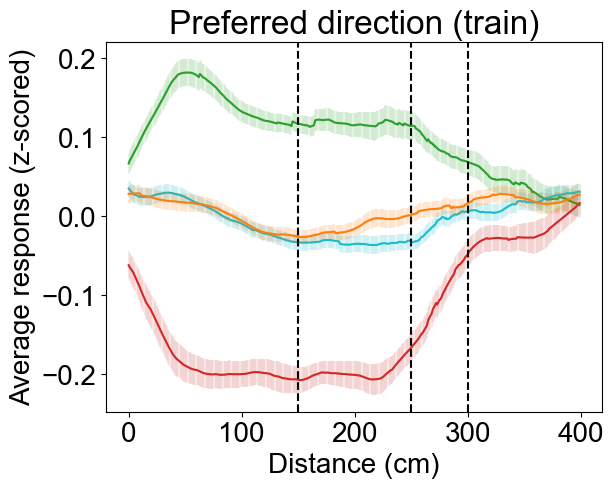

In [17]:
from scipy.stats import sem
dir_for_type = m1.interp_spks 
dir_for_type = dir_for_type[prefer_r] - dir_for_type[prefer_nr]
avg_dir = dir_for_type.mean(0)
for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()): 
    if ttype in ['rewarded', 'non rewarded']:    
        trials = trials[::2] # even trials only
        avg_dir_plot = avg_dir[trials]
        plt.errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
        plt.plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
    else:
        avg_dir_plot = avg_dir[trials]
        plt.errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
        plt.plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
plt.axvline(x=150, color='k', linestyle='--')
plt.axvline(x=250, color='k', linestyle='--')
plt.axvline(x=300, color='k', linestyle='--')
plt.xlabel('Distance (cm)')
plt.ylabel('Average response (z-scored)')
plt.title('Preferred direction (train)')

Text(0.5, 1.0, 'Preferred direction (test)')

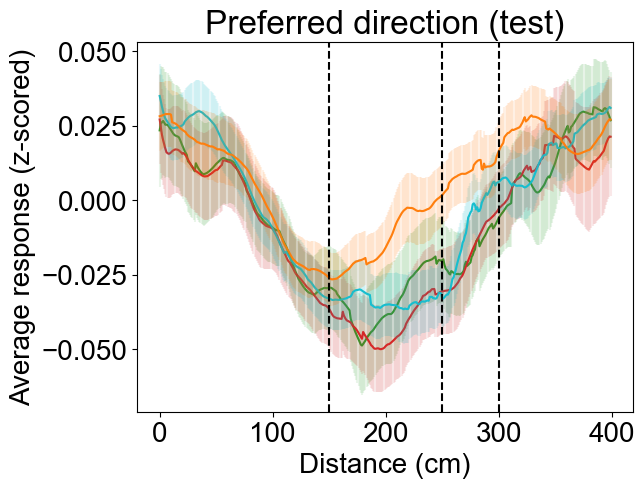

In [18]:
from scipy.stats import sem
dir_for_type = m1.interp_spks 
dir_for_type = dir_for_type[prefer_r] - dir_for_type[prefer_nr]
avg_dir = dir_for_type.mean(0)
for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()): 
    if ttype in ['rewarded', 'non rewarded']:    
        trials = trials[1::2] # test: odd trials only
        avg_dir_plot = avg_dir[trials]
        plt.errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
        plt.plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
    else:
        avg_dir_plot = avg_dir[trials]
        plt.errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
        plt.plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
plt.axvline(x=150, color='k', linestyle='--')
plt.axvline(x=250, color='k', linestyle='--')
plt.axvline(x=300, color='k', linestyle='--')
plt.xlabel('Distance (cm)')
plt.ylabel('Average response (z-scored)')
plt.title('Preferred direction (test)')

# optimal behavior session

In [19]:
m2 = utils.load_mouse('VG15','2024_10_31', '2', load_neurons=True, interp_behav=True, load_retinotopy=False)
m2.frameselector = utils.get_frameselector(m2)
istim_df = pd.DataFrame(m2._timeline['istim'], columns=['istim'])
istim_df["trial_no"] = np.arange(0, len(istim_df)).astype(float)
m2.frameselector = pd.merge(m2.frameselector, istim_df, left_on='trial_no', right_on='trial_no', how='left')
m2._spks = m2._spks[m2._snr>=.25]
m2._xpos = m2._xpos[m2._snr>=.25]
m2._ypos = m2._ypos[m2._snr>=.25]
m2._iplane = m2._iplane[m2._snr>=.25]
m2.interp_spks = utils.interp_spks_by_corridorlength(m2, m2.frameselector, z = True, corridor_length=400)

Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG15\2024_10_31\2
Creating new mouse object ...
Timeline with fname: Timeline_VG15_2024_10_31_2.mat not found, trying with fname: VG15_2024_10_31_2.mat 
Timeline file is in v7.3 format, loading with h5py
planes: 20


100%|██████████| 20/20 [05:36<00:00, 16.80s/it]


*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr'])
0 13206
interpolating 22309 neurons, 13207 frames to
the vector of distance with shape: (13207,)
neurons: 22309, trials: 399, corridor length: 400


In [20]:
m2.trial_dict = utils.get_trialno_bytype(m2.frameselector)
opt_dict = {
    "rewarded": "tab:green",
    "non rewarded": "tab:red",
    "rewarded test": "tab:cyan",
    "non rewarded test": "tab:orange",
}
utils.compute_dprime(m2, discrimination_region = (25,275), corridor_length = 400, nogray = False)
tsh = 95 # percentile threshold
if tsh > 1: # in the case we want to use a percentile
    pstv_tsh = np.percentile(m2.train_dp, tsh) #positive threshold
    ngtv_tsh = np.percentile(m2.train_dp, 100-tsh)
else: # in the case we want to use a fixed value (needs to be a number lower than 1)
    pstv_tsh = tsh
    ngtv_tsh = -tsh
# collect the neurons in that area-layer that are above and below the tresh

dprime saved in MouseObject.train_dp (neurons) using even trials
projected_response saved in MouseObject.projected_response (neurons x trials x positions)


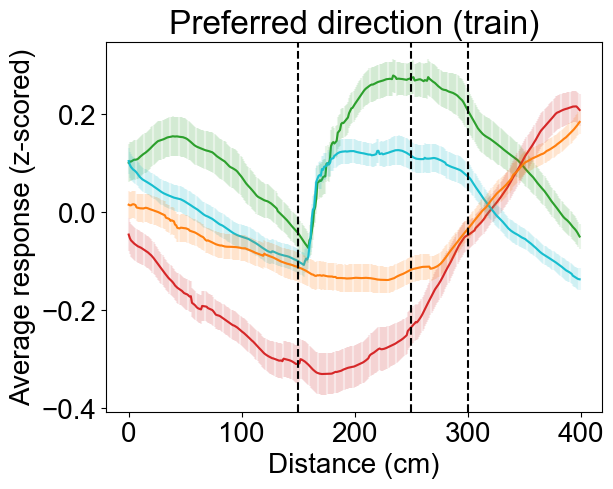

In [21]:
from scipy.stats import sem
prefer_r = (m2.train_dp>=pstv_tsh)
prefer_nr = (m2.train_dp<=ngtv_tsh)
dir_for_type = m2.interp_spks 
dir_for_type = dir_for_type[prefer_r] - dir_for_type[prefer_nr]
avg_dir = dir_for_type.mean(0)
for i_t, (ttype, trials) in enumerate(m2.trial_dict.items()): 
    if ttype in ['rewarded', 'non rewarded']:    
        trials = trials[::2] # test on odd trials only
        avg_dir_plot = avg_dir[trials]
        plt.errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
        plt.plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
    else:
        avg_dir_plot = avg_dir[trials]
        plt.errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
        plt.plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
plt.xlabel('Distance (cm)')
plt.ylabel('Average response (z-scored)')
plt.title('Preferred direction (train)')
plt.axvline(x=150, color='k', linestyle='--')
plt.axvline(x=250, color='k', linestyle='--')
plt.axvline(x=300, color='k', linestyle='--')

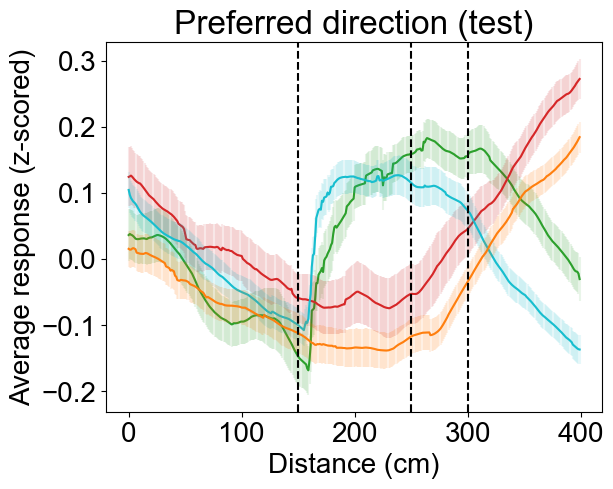

In [22]:
from scipy.stats import sem
dir_for_type = m2.interp_spks 
dir_for_type = dir_for_type[prefer_r] - dir_for_type[prefer_nr]
avg_dir = dir_for_type.mean(0)
for i_t, (ttype, trials) in enumerate(m2.trial_dict.items()): 
    if ttype in ['rewarded', 'non rewarded']:    
        trials = trials[1::2] # test on odd trials only
        avg_dir_plot = avg_dir[trials]
        plt.errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
        plt.plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
    else:
        avg_dir_plot = avg_dir[trials]
        plt.errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
        plt.plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
plt.xlabel('Distance (cm)')
plt.ylabel('Average response (z-scored)')
plt.title('Preferred direction (test)')
plt.axvline(x=150, color='k', linestyle='--')
plt.axvline(x=250, color='k', linestyle='--')
plt.axvline(x=300, color='k', linestyle='--')

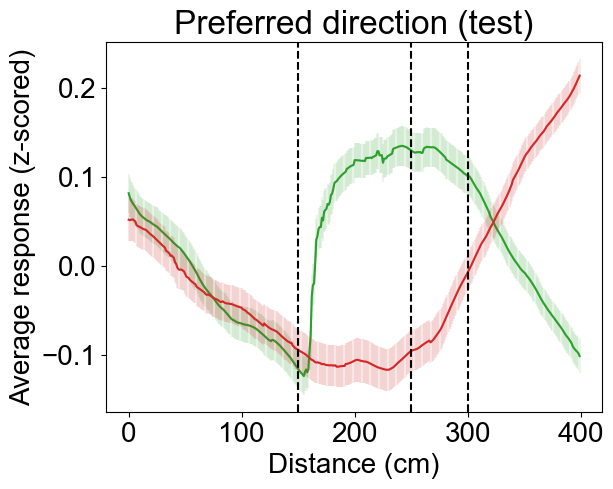

In [23]:
all_rew = np.concatenate([m2.trial_dict['rewarded'][1::2], m2.trial_dict['rewarded test']])
all_nrew = np.concatenate([m2.trial_dict['non rewarded'][1::2], m2.trial_dict['non rewarded test']])

all_dict = {
    "rewarded": all_rew,
    "non rewarded": all_nrew,
}
from scipy.stats import sem
dir_for_type = m2.interp_spks 
dir_for_type = dir_for_type[prefer_r] - dir_for_type[prefer_nr]
avg_dir = dir_for_type.mean(0)
for i_t, (ttype, trials) in enumerate(all_dict.items()): 
    if ttype in ['rewarded', 'non rewarded']:    
        avg_dir_plot = avg_dir[trials]
        plt.errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
        plt.plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
plt.xlabel('Distance (cm)')
plt.ylabel('Average response (z-scored)')
plt.title('Preferred direction (test)')
plt.axvline(x=150, color='k', linestyle='--')
plt.axvline(x=250, color='k', linestyle='--')
plt.axvline(x=300, color='k', linestyle='--')

# lick contribution

In [24]:
trials_licks = {}
trials_nolicks = {}
for k in m2.trial_dict.keys():
    t_licks, t_no_licks = utils.get_trials_with_licks(m2, lick_window=(150,250), trialtype=k)
    trials_licks[k] = t_licks
    trials_nolicks[k] = t_no_licks

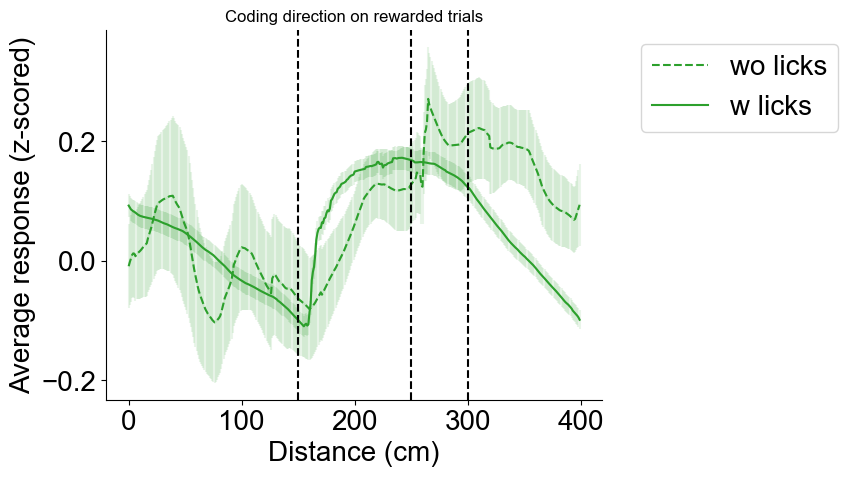

In [25]:
rtrials_nolick  = np.concatenate([trials_nolicks['rewarded'], trials_nolicks['rewarded test']])
rtrials_wlick  = np.concatenate([trials_licks['rewarded'], trials_licks['rewarded test']])
avg_dir_plot = avg_dir[rtrials_nolick]
plt.errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict['rewarded'], alpha = 0.1)
plt.plot(avg_dir_plot.mean(0), color = opt_dict['rewarded'], linewidth = 1.5, linestyle='--', label='wo licks')
avg_dir_plot = avg_dir[rtrials_wlick]
plt.errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict['rewarded'], alpha = 0.1)
plt.plot(avg_dir_plot.mean(0), color = opt_dict['rewarded'], linewidth = 1.5, label='w licks')
plt.xlabel('Distance (cm)')
plt.ylabel('Average response (z-scored)')
plt.title('Coding direction on rewarded trials', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()
plt.axvline(x=150, color='k', linestyle='--')
plt.axvline(x=250, color='k', linestyle='--')
plt.axvline(x=300, color='k', linestyle='--')



## distribution of mistakes on rewarded trials:

In [26]:
istim_df.loc[istim_df['trial_no'].isin(rtrials_nolick),"istim"].value_counts()

1.0     9
5.0     1
30.0    1
Name: istim, dtype: int64

Text(0, 0.5, 'Rewarded trials wo licks')

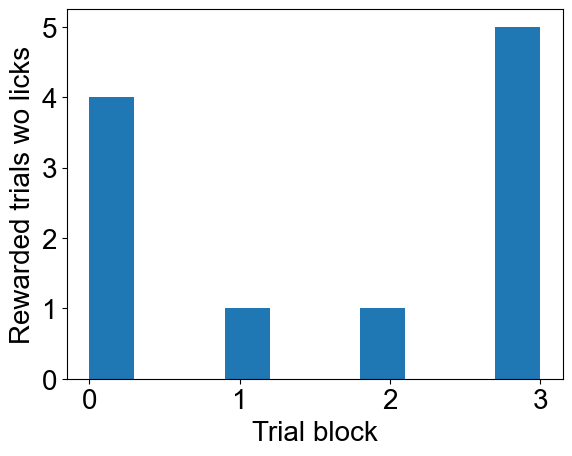

In [27]:
sorted_r_wlick = np.sort((rtrials_nolick))
plt.hist(pd.cut(sorted_r_wlick, bins=[0,100,201,301,400], labels=False));
plt.xlabel('Trial block')
plt.ylabel('Rewarded trials wo licks')

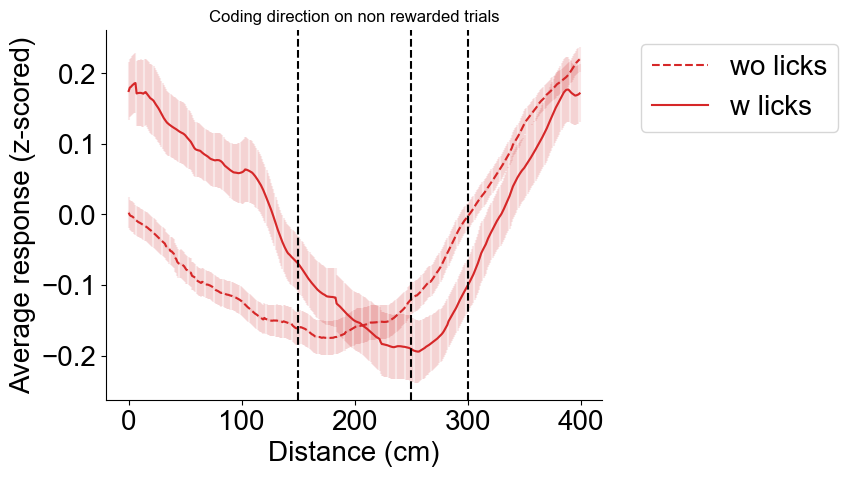

In [28]:
nrtrials_nolick  = np.concatenate([trials_nolicks['non rewarded'], trials_nolicks['non rewarded test']])
nrtrials_wlick  = np.concatenate([trials_licks['non rewarded'], trials_licks['non rewarded test']])
avg_dir_plot = avg_dir[nrtrials_nolick]
plt.errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict['non rewarded'], alpha = 0.1)
plt.plot(avg_dir_plot.mean(0), color = opt_dict['non rewarded'], linewidth = 1.5, linestyle='--', label='wo licks')
avg_dir_plot = avg_dir[nrtrials_wlick]
plt.errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict['non rewarded'], alpha = 0.1)
plt.plot(avg_dir_plot.mean(0), color = opt_dict['non rewarded'], linewidth = 1.5, label='w licks')
plt.xlabel('Distance (cm)')
plt.ylabel('Average response (z-scored)')
plt.title('Coding direction on non rewarded trials', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()
plt.axvline(x=150, color='k', linestyle='--')
plt.axvline(x=250, color='k', linestyle='--')
plt.axvline(x=300, color='k', linestyle='--')

## distribution of mistakes on non rewarded trials:

In [29]:
istim_df.loc[istim_df['trial_no'].isin(nrtrials_wlick),"istim"].value_counts()

1.0     13
11.0     2
41.0     2
33.0     2
2.0      1
4.0      1
10.0     1
8.0      1
25.0     1
27.0     1
40.0     1
31.0     1
22.0     1
23.0     1
Name: istim, dtype: int64

Text(0, 0.5, 'Non rewarded trials with licks')

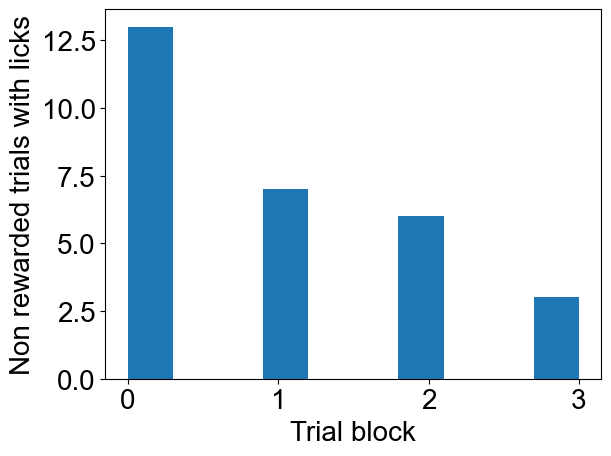

In [30]:
sorted_nr_wlick = np.sort((nrtrials_wlick))
plt.hist(pd.cut(sorted_nr_wlick, bins=[0,100,201,301,400], labels=False));
plt.xlabel('Trial block')
plt.ylabel('Non rewarded trials with licks')

# dprime (>.45) comparison and position
## first day

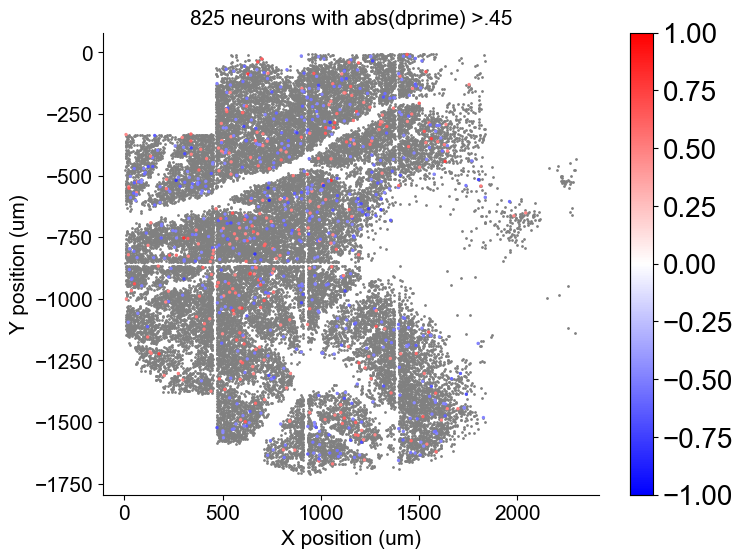

In [31]:
#selected_neurons = np.abs(m1.train_dp) > np.percentile(m1.train_dp, 95)
selected_neurons = np.abs(m1.train_dp) > .45
plt.figure(figsize=(8,6))
plt.scatter(m1._xpos, -m1._ypos, c = 'gray', s = 1)
plt.scatter(m1._xpos[selected_neurons], -m1._ypos[selected_neurons], c = m1.train_dp[selected_neurons], cmap = 'bwr', vmax = 1, vmin=-1, s = 2);
plt.title(f"{selected_neurons.sum()} neurons with abs(dprime) >.45", size=15)
plt.xlabel('X position (um)', fontsize=15);
plt.ylabel('Y position (um)', fontsize=15);
plt.tick_params(labelsize=15)
plt.colorbar()
sns.despine()

## last day

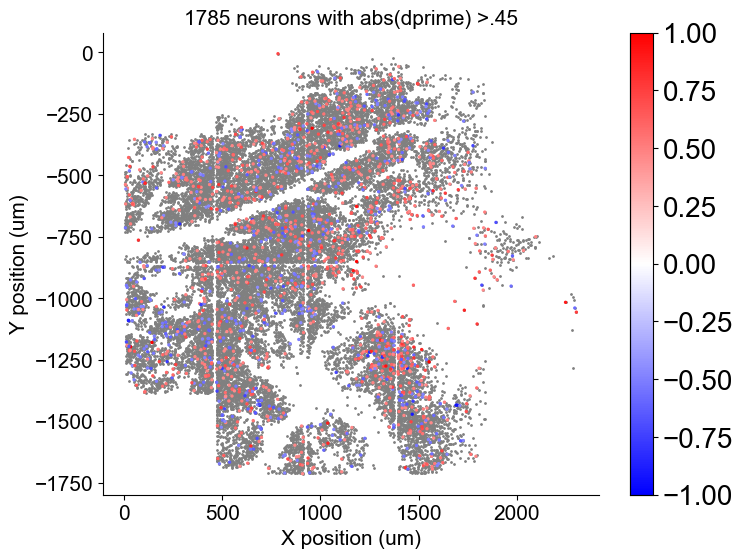

In [32]:
#selected_neurons = np.abs(m2.train_dp) > np.percentile(m2.train_dp, 95)
selected_neurons = np.abs(m2.train_dp) > .45
plt.figure(figsize=(8,6))
plt.scatter(m2._xpos, -m2._ypos, c = 'gray', s = 1)
plt.scatter(m2._xpos[selected_neurons], -m2._ypos[selected_neurons], c = m2.train_dp[selected_neurons], cmap = 'bwr', vmax = 1, vmin=-1, s = 2);
plt.title(f"{selected_neurons.sum()} neurons with abs(dprime) >.45", size=15)
plt.xlabel('X position (um)', fontsize=15);
plt.ylabel('Y position (um)', fontsize=15);
plt.tick_params(labelsize=15)
plt.colorbar()
sns.despine()

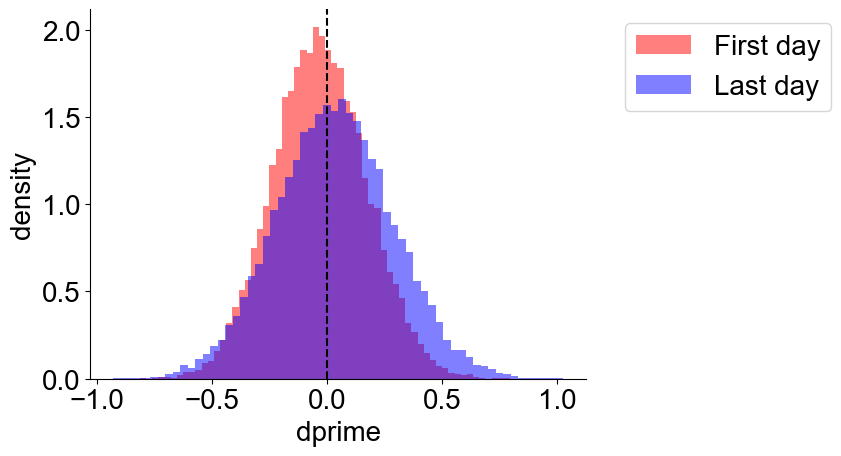

In [33]:
plt.hist(m1.train_dp, bins=60, color='red', alpha=0.5, density=True, label='First day');
plt.hist(m2.train_dp, bins=60, color='blue', alpha=0.5, density=True, label='Last day');
# reference line at 0
plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel('dprime')
plt.ylabel('density')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()



# there are neurons that can separate both categories in the first half of the corridor?

In [34]:
m2.trial_dict = utils.get_trialno_bytype(m2.frameselector)
opt_dict = {
    "rewarded": "tab:green",
    "non rewarded": "tab:red",
    "rewarded test": "tab:cyan",
    "non rewarded test": "tab:orange",
}
utils.compute_dprime(m2, discrimination_region = (25,150), corridor_length = 400, nogray = False) # first half
tsh = 95 # percentile threshold
if tsh > 1: # in the case we want to use a percentile
    pstv_tsh = np.percentile(m2.train_dp, tsh) #positive threshold
    ngtv_tsh = np.percentile(m2.train_dp, 100-tsh)
else: # in the case we want to use a fixed value (needs to be a number lower than 1)
    pstv_tsh = tsh
    ngtv_tsh = -tsh
# collect the neurons in that area-layer that are above and below the tresh
prefer_r = (m2.train_dp>=pstv_tsh)
prefer_nr = (m2.train_dp<=ngtv_tsh)

dprime saved in MouseObject.train_dp (neurons) using even trials
projected_response saved in MouseObject.projected_response (neurons x trials x positions)


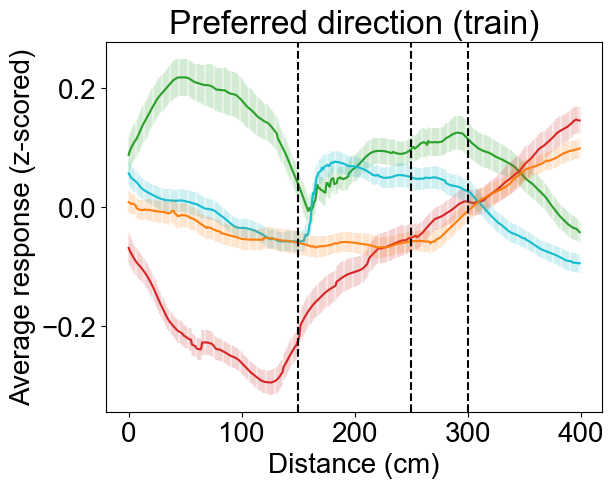

In [35]:
dir_for_type = m2.interp_spks 
dir_for_type = dir_for_type[prefer_r] - dir_for_type[prefer_nr]
avg_dir = dir_for_type.mean(0)
for i_t, (ttype, trials) in enumerate(m2.trial_dict.items()): 
    if ttype in ['rewarded', 'non rewarded']:    
        trials = trials[::2] # test on odd trials only
        avg_dir_plot = avg_dir[trials]
        plt.errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
        plt.plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
    else:
        avg_dir_plot = avg_dir[trials]
        plt.errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
        plt.plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
plt.xlabel('Distance (cm)')
plt.ylabel('Average response (z-scored)')
plt.title('Preferred direction (train)')
plt.axvline(x=150, color='k', linestyle='--')
plt.axvline(x=250, color='k', linestyle='--')
plt.axvline(x=300, color='k', linestyle='--')

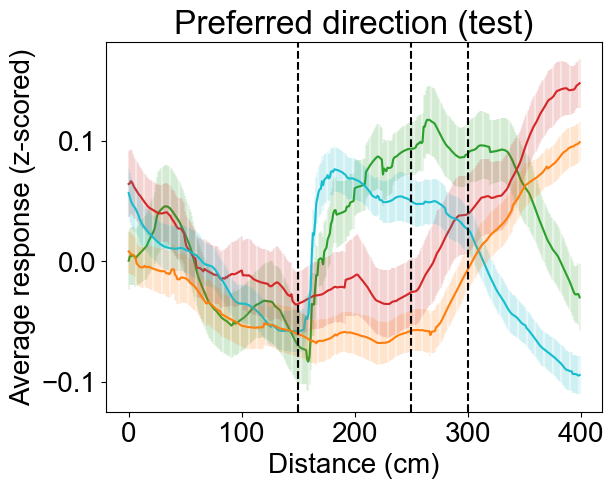

In [36]:
from scipy.stats import sem
dir_for_type = m2.interp_spks 
dir_for_type = dir_for_type[prefer_r] - dir_for_type[prefer_nr]
avg_dir = dir_for_type.mean(0)
for i_t, (ttype, trials) in enumerate(m2.trial_dict.items()): 
    if ttype in ['rewarded', 'non rewarded']:    
        trials = trials[1::2] # test on odd trials only
        avg_dir_plot = avg_dir[trials]
        plt.errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
        plt.plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
    else:
        avg_dir_plot = avg_dir[trials]
        plt.errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
        plt.plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
plt.xlabel('Distance (cm)')
plt.ylabel('Average response (z-scored)')
plt.title('Preferred direction (test)')
plt.axvline(x=150, color='k', linestyle='--')
plt.axvline(x=250, color='k', linestyle='--')
plt.axvline(x=300, color='k', linestyle='--')

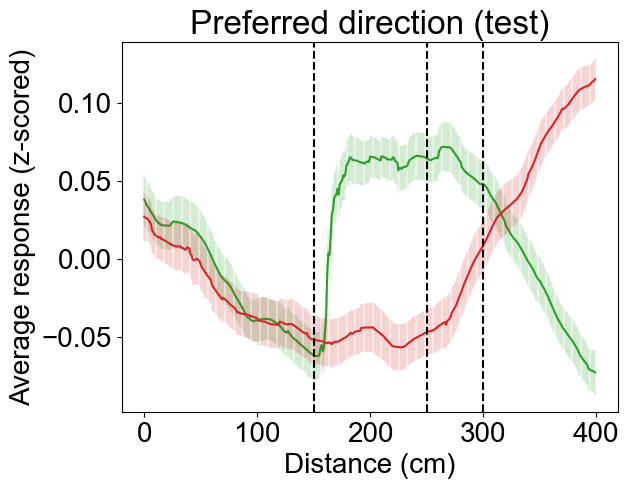

In [37]:
all_rew = np.concatenate([m2.trial_dict['rewarded'][1::2], m2.trial_dict['rewarded test']])
all_nrew = np.concatenate([m2.trial_dict['non rewarded'][1::2], m2.trial_dict['non rewarded test']])

all_dict = {
    "rewarded": all_rew,
    "non rewarded": all_nrew,
}
from scipy.stats import sem
dir_for_type = m2.interp_spks 
dir_for_type = dir_for_type[prefer_r] - dir_for_type[prefer_nr]
avg_dir = dir_for_type.mean(0)
for i_t, (ttype, trials) in enumerate(all_dict.items()): 
    if ttype in ['rewarded', 'non rewarded']:    
        avg_dir_plot = avg_dir[trials]
        plt.errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
        plt.plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
plt.xlabel('Distance (cm)')
plt.ylabel('Average response (z-scored)')
plt.title('Preferred direction (test)')
plt.axvline(x=150, color='k', linestyle='--')
plt.axvline(x=250, color='k', linestyle='--')
plt.axvline(x=300, color='k', linestyle='--')

In [38]:
del m1, m2 #space

# what happened in the all rewarded day after optimal behavior?

In [39]:
m3 = utils.load_mouse('VG15','2024_11_01', '3', load_neurons=True, interp_behav=True, load_retinotopy=False)
m3.frameselector = utils.get_frameselector(m3)
istim_df = pd.DataFrame(m3._timeline['istim'], columns=['istim'])
istim_df["trial_no"] = np.arange(0, len(istim_df)).astype(float)
m3.frameselector = pd.merge(m3.frameselector, istim_df, left_on='trial_no', right_on='trial_no', how='left')
m3._spks = m3._spks[m3._snr>=.25]
m3._xpos = m3._xpos[m3._snr>=.25]
m3._ypos = m3._ypos[m3._snr>=.25]
m3._iplane = m3._iplane[m3._snr>=.25]
m3.interp_spks = utils.interp_spks_by_corridorlength(m3, m3.frameselector, z = True, corridor_length=400)

Checking if model object exists ...
*************************************
Model object does not exist in path:
C:\Users\labadmin\Documents\models\mouseobj\VG15\2024_11_01\3
Creating new mouse object ...
Timeline with fname: Timeline_VG15_2024_11_01_3.mat not found, trying with fname: VG15_2024_11_01_3.mat 
Timeline file is in v7.3 format, loading with h5py
planes: 20


100%|██████████| 20/20 [05:15<00:00, 15.78s/it]


*************************************
mouse object created with the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr'])
0 14710
interpolating 20669 neurons, 14711 frames to
the vector of distance with shape: (14711,)
neurons: 20669, trials: 399, corridor length: 400


In [40]:
m3.trial_dict = utils.get_trialno_bytype(m3.frameselector)
opt_dict = {
    "rewarded": "tab:green",
    "non rewarded": "tab:red",
    "rewarded test": "tab:cyan",
    "non rewarded test": "tab:orange",
}
utils.compute_dprime(m3, discrimination_region = (25,275), corridor_length = 400, nogray = False)
tsh = 95 # percentile threshold
if tsh > 1: # in the case we want to use a percentile
    pstv_tsh = np.percentile(m3.train_dp, tsh) #positive threshold
    ngtv_tsh = np.percentile(m3.train_dp, 100-tsh)
else: # in the case we want to use a fixed value (needs to be a number lower than 1)
    pstv_tsh = tsh
    ngtv_tsh = -tsh
# collect the neurons in that area-layer that are above and below the tresh

dprime saved in MouseObject.train_dp (neurons) using even trials
projected_response saved in MouseObject.projected_response (neurons x trials x positions)


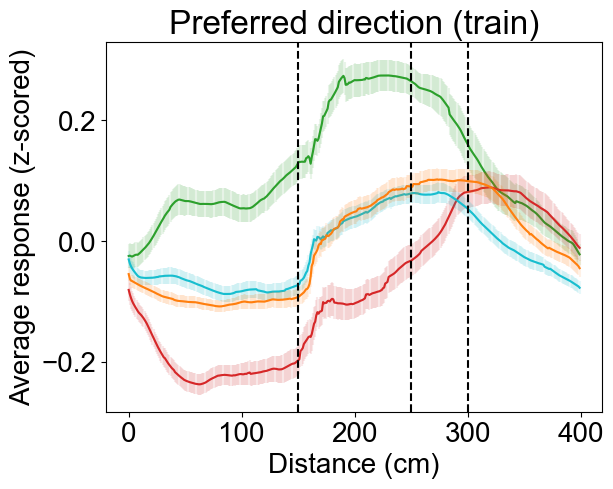

In [41]:
from scipy.stats import sem
prefer_r = (m3.train_dp>=pstv_tsh)
prefer_nr = (m3.train_dp<=ngtv_tsh)
dir_for_type = m3.interp_spks 
dir_for_type = dir_for_type[prefer_r] - dir_for_type[prefer_nr]
avg_dir = dir_for_type.mean(0)
for i_t, (ttype, trials) in enumerate(m3.trial_dict.items()): 
    if ttype in ['rewarded', 'non rewarded']:    
        trials = trials[::2] # test on odd trials only
        avg_dir_plot = avg_dir[trials]
        plt.errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
        plt.plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
    else:
        avg_dir_plot = avg_dir[trials]
        plt.errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
        plt.plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
plt.xlabel('Distance (cm)')
plt.ylabel('Average response (z-scored)')
plt.title('Preferred direction (train)')
plt.axvline(x=150, color='k', linestyle='--')
plt.axvline(x=250, color='k', linestyle='--')
plt.axvline(x=300, color='k', linestyle='--')

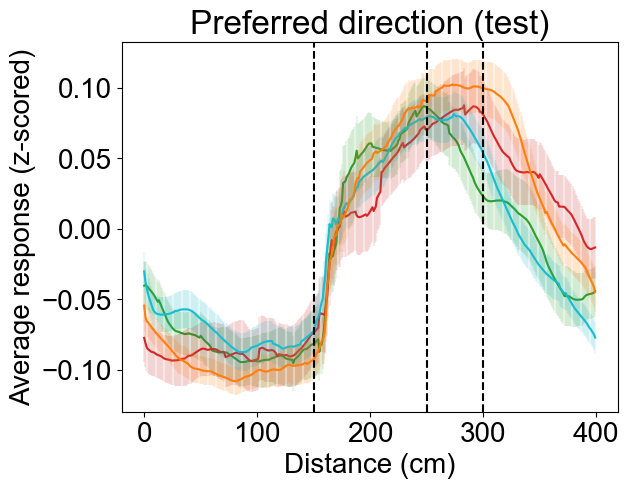

In [42]:
for i_t, (ttype, trials) in enumerate(m3.trial_dict.items()): 
    if ttype in ['rewarded', 'non rewarded']:    
        trials = trials[1::2] # test on odd trials only
        avg_dir_plot = avg_dir[trials]
        plt.errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
        plt.plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
    else:
        avg_dir_plot = avg_dir[trials]
        plt.errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
        plt.plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
plt.xlabel('Distance (cm)')
plt.ylabel('Average response (z-scored)')
plt.title('Preferred direction (test)')
plt.axvline(x=150, color='k', linestyle='--')
plt.axvline(x=250, color='k', linestyle='--')
plt.axvline(x=300, color='k', linestyle='--')

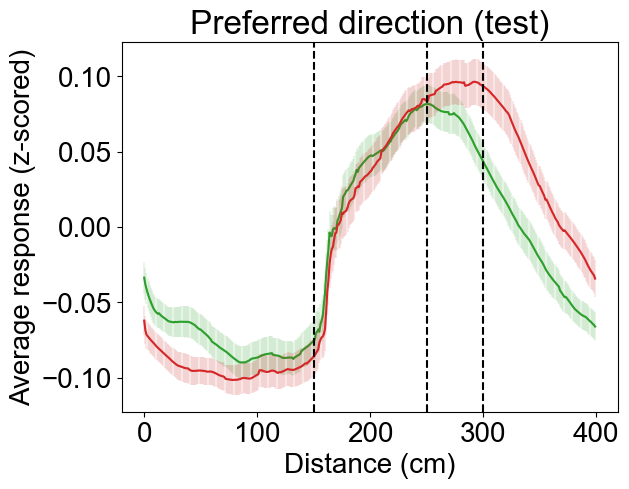

In [43]:
all_rew = np.concatenate([m3.trial_dict['rewarded'][1::2], m3.trial_dict['rewarded test']])
all_nrew = np.concatenate([m3.trial_dict['non rewarded'][1::2], m3.trial_dict['non rewarded test']])

all_dict = {
    "rewarded": all_rew,
    "non rewarded": all_nrew,
}
for i_t, (ttype, trials) in enumerate(all_dict.items()): 
    if ttype in ['rewarded', 'non rewarded']:    
        avg_dir_plot = avg_dir[trials]
        plt.errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
        plt.plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
plt.xlabel('Distance (cm)')
plt.ylabel('Average response (z-scored)')
plt.title('Preferred direction (test)')
plt.axvline(x=150, color='k', linestyle='--')
plt.axvline(x=250, color='k', linestyle='--')
plt.axvline(x=300, color='k', linestyle='--')

What if we only take the first few trials? Does the brain represent the prior knowledge about the categories?

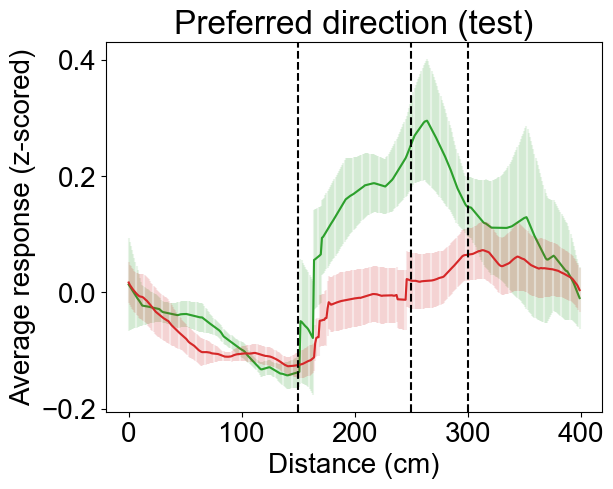

In [44]:
all_dict = {
    "rewarded": all_rew[all_rew<20],
    "non rewarded": all_nrew[all_nrew<20],
}
for i_t, (ttype, trials) in enumerate(all_dict.items()): 
    if ttype in ['rewarded', 'non rewarded']:    
        avg_dir_plot = avg_dir[trials]
        plt.errorbar(np.arange(0,400), avg_dir_plot.mean(0), sem(avg_dir_plot), color = opt_dict[ttype], alpha = 0.1)
        plt.plot(avg_dir_plot.mean(0), color = opt_dict[ttype], linewidth = 1.5)
plt.xlabel('Distance (cm)')
plt.ylabel('Average response (z-scored)')
plt.title('Preferred direction (test)')
plt.axvline(x=150, color='k', linestyle='--')
plt.axvline(x=250, color='k', linestyle='--')
plt.axvline(x=300, color='k', linestyle='--')